# Quick start

In this quick tutorial we will learn how to create a simple model with one point source, with a power law spectrum. You can of course use any function instead of the power law. Use "list_models()" to obtain a list of available models.

Let's define the model:

In [1]:
from astromodels import *

test_source = PointSource('test_source',ra=123.22, dec=-13.56, spectral_shape=powerlaw_flux())

my_model = Model(test_source)

/home/giacomov/software/canopy-env/lib/python2.7/site-packages/astromodels-0.1-py2.7.egg/astromodels/functions/functions.py:39: NaimaNotAvailable: The naima package is not available. Models that depend on it will not be available


Now let's use it:

In [2]:
# Get and print the differential flux at 1 keV:

differential_flux_at_1_keV = my_model.test_source(1.0 * u.keV)

print("Differential flux @ 1 keV : %s" % differential_flux_at_1_keV)

Differential flux @ 1 keV : 1.0101010101 1 / (cm2 keV s)


In [3]:
# Evaluate the model on an array of 100 energies logarithmically distributed between 1 and 100 keV

# Set up the energies

energies = np.logspace(0,2,100)

# Get the differential flux

differential_flux = my_model.test_source(energies * u.keV)

/home/giacomov/software/canopy-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


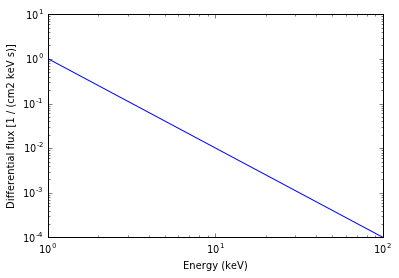

In [4]:
# Plot it with the help of matplotlib 
# Matplotlib is not required by astromodels, although you need it
# for this part of the example

import matplotlib.pyplot as plt

# Do not execute this if you are not using the IPython notebook

########

%matplotlib inline

########

plt.loglog(energies, differential_flux)

plt.xlabel("Energy (keV)")
plt.ylabel("Differential flux [%s]" % differential_flux.unit)

# Fitting simple 1d data using astromodels

Astromodels is not a fitting package. It merely defines the model to be fitted to the data. However, using it with existing optimization packages is fairly easy. If you have a simple 1d dataset with no spatial information, then you can model it by just using the functions in astromodels. You don't need to even instance the Model class, which is made for more complex situations. Here are some examples:

## Chisq. minimization with curve_fit

This is a quick method if you have data with Gaussian errors. scipy.optimize.curve_fit creates and minimize $\chi^2$ for you, you only need to provide the fitting function. This is a complete example:


Best fit parameters:

  name  value  error 
------- ------ ------
    a_1   1.00  0.012
    b_1   1.32  0.094
    F_2 289.39 27.126
   mu_2  40.78  0.329
sigma_2   3.22  0.308


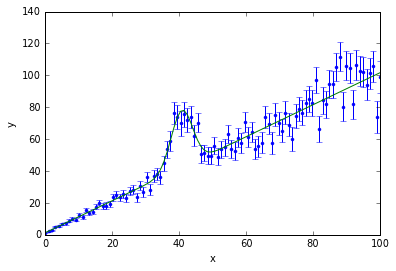

In [5]:
import numpy as np
import scipy.optimize
from astromodels import *
from astromodels.utils.table import dict_to_table
import collections

# Instance a composite function composed by a line and a Gaussian

fit_func = line(b=1.2) + gaussian(mu=40.5, F=10**2.5, sigma=3.4)

# Generate some fake data

xdata = np.linspace(0, 100, 100)

y = fit_func(xdata)

# Add Gaussian noise

yerr = 0.1 * np.abs(y)

ydata = np.random.normal(y, yerr)

# Initial guess for the fit: let's start a bit off so the
# fitting function actually needs to do something

p0 = [1.1, 1.3, 1.6, 40.5, 0.5]

# Make the bounds tuple, i.e., the constraints on the parameters

minima = []
maxima = []

for parameter in fit_func.free_parameters.values():
    
    # scipy doesn't like None (which in astromodel means no boundary in that direction) 
    # It instead uses np.inf to indicate no boundary (with the appropriate sign)
    
    this_minimum = parameter.min_value if parameter.min_value is not None else -np.inf
    this_maximum = parameter.max_value if parameter.max_value is not None else np.inf
    
    minima.append(this_minimum)
    maxima.append(this_maximum)
    
# Perform the fit
# NOTE: we use .get_wrapper to get a function which is in the form expected
# by scipy, which is f(x, param1, param2...)

popt, pcov = scipy.optimize.curve_fit(fit_func.get_wrapper(), xdata, ydata, 
                                      p0=p0, sigma=yerr, absolute_sigma=True,
                                      bounds=(minima, maxima), verbose=0)

# Compute the approximate errors as the square root of the diagonal of the covariance matrix

perr = np.sqrt(np.diag(pcov))

# Plot data and model

plt.errorbar(xdata,ydata,yerr=yerr,fmt='.')
plt.plot(xdata,fit_func(xdata))
_ = plt.xlabel("x")
_ = plt.ylabel("y")

# Print the results
# Since we are at it, let's put the results in a nice table

print("\nBest fit parameters:\n")

results = collections.OrderedDict()

for i, par_name in enumerate(fit_func.free_parameters.keys()):
    
    results[par_name] = {'value': '%.2f' % popt[i], 'error': '%.3f' % perr[i]}

print(dict_to_table(results))

## Maximum likelihood with scipy and astromodels

This is a similar example where we minimize the -logLikelihood instead of chisq, using the scipy.optimize package:

Starting values: [10.077659938239558, -1.9608533665741636, 26.190288643926063, 0.32458474356450123, 0.019107521535890213]
100 loops, best of 3: 13.6 ms per loop

Minimum of -log(likelihood): -64489.3443832


Best fit parameters:

  name  value error
------- ----- -----
    K_1 10.08 0.100
index_1 -2.00 0.100
    F_2 26.19 0.100
   mu_2  0.35 0.100
sigma_2  0.02 0.100


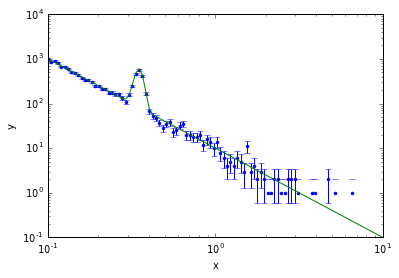

In [14]:
import numpy as np
import scipy.optimize
from astromodels import *
from astromodels.utils.table import dict_to_table
import collections
import matplotlib.pyplot as plt

# Use this only in the ipython notebook
%matplotlib inline

# Create a log-likelihood class, which will provide the objective function
# to minimize (the -log(likelihood) in this case)

class LogLike(object):
    
    def __init__(self, x, y, function):
        
        # Store data and model instance
        
        self.x = x
        self.y = y
        self.function = function
        
        # Get the dictionary of free parameters
        # (we assume that it will not change after construction)
        self.free_parameters = self.function.free_parameters
    
    def minus_log_like(self, new_values):
                
        # This method computes the -log(like) given the new parameters' values        
        
        # Assume we have the right number of values in input
        
        assert len(self.free_parameters) == len(new_values), "wrong number of parameters"
        
        # Assign the new values to the free parameters
        
        for i, par in enumerate(self.free_parameters.values()):
            
            par.scaled_value = new_values[i]
        
        # Evaluate the model
        # (we assume there is only one point source)
        
        m = self.function(self.x)
        
        # In Poisson likelihood models cannot be negative. Enforce this, however
        # keep in mind that due to precision error values could be close to zero
        
        if np.any(np.abs(m + 1e-6) < 0):
            
            # Return a big value for the -log(like) so the fitting
            # engine will stay away
            return 1e6
        
        # The Poisson log. likelihood is
        # the sum of y_{i} log(m_i) - m_i
        # (we ignore the term log(y_i!) which is irrelevant for the fit)
        # where y_i and m_i are respectively the observed
        # number of counts and the value of the model in the i-th bin
        
        loglike = np.sum(self.y * np.log(m) - m)
        
        #print("%s -> %s" % (new_values, -loglike))
        
        return -loglike


# Instance a composite function composed by a power law and a Gaussian

fit_func = powerlaw(K=10.0,piv=1.0) + gaussian(mu=0.35, F=10**1.4, sigma=0.02)

# Generate some fake data

xdata = np.logspace(-1, 1, 100)

y = fit_func(xdata)

# Create the data with Poisson noise

ydata = np.random.poisson(y)

# Now instance the loglike class for the particular data we have
this_log_like = LogLike(xdata,ydata,fit_func)

# Initial guess for the fit: let's start a bit off so the
# fitting function actually needs to do something

p0 = map(lambda x:x.get_randomized_value(variance=0.05), fit_func.free_parameters.values())

print("Starting values: %s" % p0)

# Make the bounds tuple, i.e., the constraints on the parameters
# (note that scipy.optimize.minimize uses a different structure for the bounds,
# which need to be a list of (min,max) tuples instead of two lists like
# scipy.optimize.curve_fit)

bounds = []

for parameter in fit_func.free_parameters.values():
    
    # scipy doesn't like None (which in astromodel means no boundary in that direction) 
    # It instead uses np.inf to indicate no boundary (with the appropriate sign)
    # Also minimize has the bad habit of setting the parameter just a tiny bit outside
    # its boundaries. So, let's restrict a little bit the range to counteract this
    
    this_minimum = (parameter.scaled_min_value + abs(parameter.min_value/1000) 
                                         if parameter.min_value is not None else -np.inf)
    this_maximum = (parameter.scaled_max_value - abs(parameter.max_value/1000) 
                                         if parameter.max_value is not None else np.inf)
    
    bounds.append((this_minimum, this_maximum))
    
# Perform the fit

res = scipy.optimize.minimize(this_log_like.minus_log_like, p0, bounds=bounds, method='L-BFGS-B')

%timeit scipy.optimize.minimize(this_log_like.minus_log_like, p0, bounds=bounds, method='L-BFGS-B')

# Plot data and model

plt.errorbar(xdata,ydata,yerr=np.sqrt(ydata),fmt='.')
plt.loglog(xdata,fit_func(xdata))
_ = plt.xlabel("x")
_ = plt.ylabel("y")

# Print the results
# Since we are at it, let's put the results in a nice table
print("\nMinimum of -log(likelihood): %s\n" % res.fun)
print("\nBest fit parameters:\n")

results = collections.OrderedDict()

for i, par_name in enumerate(fit_func.free_parameters.keys()):
    
    results[par_name] = {'value': '%.2f' % res.x[i], 'error': '%.3f' % 0.1}

print(dict_to_table(results))

## Maximum likelihood fit with iminuit

iminuit (http://iminuit.readthedocs.org/) is a python wrapper for the MINUIT fitting algorithm, and it is very convenient for fitting in python. Here is an example, very similary to the previous one, but using iminuit instead of scipy:

100 loops, best of 3: 2.43 ms per loop

Best fit parameters:

  name  value error
------- ----- -----
    K_1  0.11 0.009
index_1 -1.99 0.020
    F_2 10.19 0.589
   mu_2  0.35 0.001
sigma_2  0.02 0.001


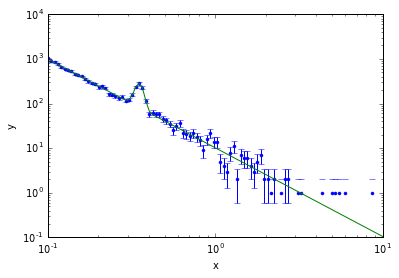

In [17]:
import numpy as np
import iminuit
from astromodels import *
from astromodels.utils.table import dict_to_table
import collections
import matplotlib.pyplot as plt

# Use this only in the ipython notebook
%matplotlib inline

# Create a log-likelihood class, which will provide the objective function
# to minimize (the -log(likelihood) in this case)

class LogLike(object):
    
    def __init__(self, x, y, function):
        
        # Store data and model instance
        
        self.x = x
        self.y = y
        self.function = function
        
        # Get the dictionary of free parameters
        # (we assume that it will not change after construction)
        self.free_parameters = self.function.free_parameters
    
    def minus_log_like(self, *new_values):
                
        # This method computes the -log(like) given the new parameters' values        
        
        # Assume we have the right number of values in input
        
        assert len(self.free_parameters) == len(new_values), "wrong number of parameters"
        
        # Assign the new values to the free parameters
        # We could do this with this for loop:
        
        for i, par in enumerate(self.free_parameters.values()):
            
            par.scaled_value = new_values[i]
        
        # Evaluate the model
        # (we assume there is only one point source)
        
        m = self.function(self.x)
        
        # In Poisson likelihood models cannot be negative. Enforce this, however
        # keep in mind that due to precision error values could be close to zero
        
        if np.any(np.abs(m + 1e-6) < 0):
            
            # Return a big value for the -log(like) so the fitting
            # engine will stay away
            return 1e6
        
        # The Poisson log. likelihood is
        # the sum of y_{i} log(m_i) - m_i
        # (we ignore the term log(y_i!) which is irrelevant for the fit)
        # where y_i and m_i are respectively the observed
        # number of counts and the value of the model in the i-th bin
        
        loglike = np.sum(self.y * np.log(m) - m)
        
        #print("%s -> %s" % (new_values, -loglike))
        
        return -loglike

# Instance a composite function composed by a power law and a Gaussian

fit_func = powerlaw(K=0.1,piv=10.0) + gaussian(mu=0.35, F=10, sigma=0.02)

# Generate some fake data

xdata = np.logspace(-1, 1, 100)

y = fit_func(xdata)

# Create the data with Poisson noise

ydata = np.random.poisson(y)

# Now instance the loglike class for the particular data we have
this_log_like = LogLike(xdata,ydata,fit_func)

# Build a dictionary with the options for iminuit

iminuit_opt = {}

# Tell minuit the name of the parameters
iminuit_opt['forced_parameters'] = map(lambda x:x.name, fit_func.free_parameters.values())

for parameter in fit_func.free_parameters.values():
    
    # Initial guess for the fit: let's start a bit off so the
    # fitting function actually needs to do something
    
    iminuit_opt[parameter.name] = parameter.get_randomized_value()
    
    iminuit_opt['error_%s' % parameter.name] = parameter.delta
    
    iminuit_opt['limit_%s' % parameter.name] = (parameter.min_value, parameter.max_value)
    
# These options are needed for a likelihood fit
iminuit_opt['errordef'] = 0.5

iminuit_opt['print_level'] = 0

# Perform the fit

minuit = iminuit.Minuit(this_log_like.minus_log_like, **iminuit_opt)

res = minuit.migrad()

# Plot data and model

plt.errorbar(xdata,ydata,yerr=np.sqrt(ydata),fmt='.')
plt.loglog(xdata,fit_func(xdata))
_ = plt.xlabel("x")
_ = plt.ylabel("y")

# Print the results
# Since we are at it, let's put the results in a nice table

print("\nBest fit parameters:\n")

results = collections.OrderedDict()

for i, par_name in enumerate(fit_func.free_parameters.keys()):
    
    results[par_name] = {'value': '%.2f' % res[1][i]['value'], 'error': '%.3f' % res[1][i]['error']}

print(dict_to_table(results))